In [30]:

import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import math as mt 
import scipy.special as sci
from matplotlib.animation import FuncAnimation
import tqdm as tqdm


## Instalar librerias

In [ ]:
pip install diffractsim ##Calculos de difraccion y algoritmos de reconstruccion de fase

In [ ]:
pip install opencv-python ##Libreria de procesamiento de imagenes

In [ ]:
pip install screeninfo ## Informacion de pantallas

##  1) FUNCIONES DE CAMPO ELECTRICO Y PATRONES DE INTENSIDAD


## Función para generar modos de haces gaussianos:

$$
\mathbf{E}(r, z) = E_0 \, \hat{x} \, \frac{w_0}{w(z)} 
\exp\left( -\frac{r^2}{w^2(z)} \right)
\exp\left( -i \left( k z + \frac{k r^2}{2R(z)} - \psi(z) \right) \right)
$$

### Donde:
- $r$ es la distancia radial desde el eje central del haz,  
- $z$ es la distancia axial desde el foco del haz (o "waist"),  
- $i$ es la unidad imaginaria,  
- $k = \frac{2\pi n}{\lambda}$ es el número de onda (en radianes por metro) para una longitud de onda en espacio libre $\lambda$, y $n$ es el índice de refracción del medio en el que el haz se propaga,  
- $E_0 = E(0,0)$ es la amplitud del campo eléctrico en el origen $(r=0, z=0)$,  
- $w(z)$ es el radio en el cual la amplitud del campo cae a $1/e$ de su valor axial (es decir, donde la intensidad cae a $1/e^2$ de su valor axial), en el plano $z$ a lo largo del haz,  
- $w_0 = w(0)$ es el radio de la cintura (waist),  
- $R(z)$ es el radio de curvatura de los frentes de onda del haz en $z$, y  
- $\psi(z) = \arctan(z/z_R)$ es la fase de Gouy en $z$, un término de fase extra más allá del atribuido a la velocidad de fase de la luz.  



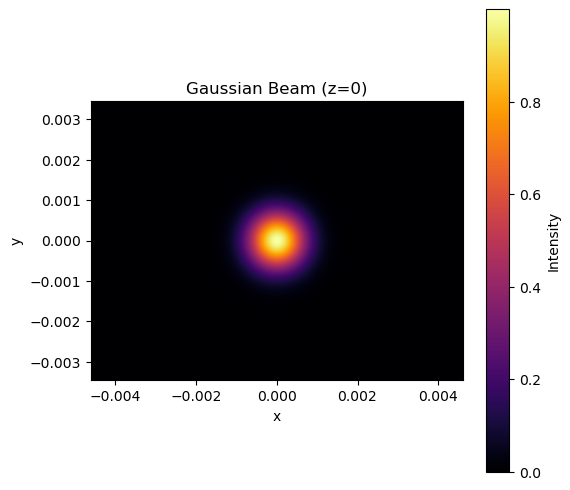

In [13]:

Nxpix = 1024 ## DIMENSIONES DEL SLM
Nypix = 768
Pix_size=9e-6 #TAMANO DEL PIXEL ES 9um

##GENERACION DE BEAMS GAUSSIANOS

def gaussian_beam(r, z, w0, k):
    """
    Computes the Gaussian beam profile based on the given equation.
    
    Parameters:
        r  : Radial coordinate
        z  : Axial coordinate (propagation distance)
        w0 : Beam waist (radius at focus)
        k  : Wave number
    
    Returns:
        Complex field amplitude of the Gaussian beam.
    """
    z_R = np.pi * w0**2 / k  # Rayleigh range
    w_z = w0 * np.sqrt(1 + (z / z_R) ** 2)  # Beam waist at z
    R_z = z * (1 + (z_R / z) ** 2) if z != 0 else np.inf  # Radius of curvature
    psi_z = np.arctan(z / z_R)  # Gouy phase
    
    amplitude = (w0 / w_z) * np.exp(-r**2 / w_z**2)
    phase = np.exp(-1j * (k * z + k * r**2 / (2 * R_z) - psi_z))
    
    return amplitude * phase

# Define grid
N = (Nxpix,Nypix)  # Grid size
x = np.linspace(-Nxpix/2*Pix_size, Nxpix/2*Pix_size, Nxpix)
y = np.linspace(-Nypix/2*Pix_size, Nypix/2*Pix_size, Nypix)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)


# Set Gaussian beam parameters
w0 = 1000* 10**-6  # Beam waist
z = 0  # Propagation distance
k = 2*np.pi/633e-9  # Wave number

# Compute beam intensity
gaussian_mode = gaussian_beam(R, z, w0, k)
intensity = np.abs(gaussian_mode) ** 2

# Plot the intensity pattern
plt.figure(figsize=(6, 6))
plt.imshow(intensity, extent=[-Nxpix/2*Pix_size, Nxpix/2*Pix_size, -Nypix/2*Pix_size, Nypix/2*Pix_size], cmap='inferno')
plt.colorbar(label='Intensity')
plt.title(f'Gaussian Beam (z={z})')
plt.xlabel('x')
plt.ylabel('y')


plt.savefig(f'FIGURAS\GaussianBeam(z={z}).png')
plt.show()




## Función de modos Laguerre-Gaussianos:

$$
u(r, \phi, z) = C_{lp}^{LG} \frac{1}{w(z)}
\left( \frac{r\sqrt{2}}{w(z)} \right)^{|l|}
\exp\left( -\frac{r^2}{w^2(z)} \right)
L_p^{|l|} \left( \frac{2r^2}{w^2(z)} \right) \times
$$

$$
\exp\left(-ik \frac{r^2}{2R(z)}\right)
\exp(-i l \phi) \exp(i \psi(z)),
$$

donde $L_p^{l}$ son los **polinomios de Laguerre generalizados**.  
$C_{lp}^{LG}$ es la constante de normalización requerida:

$$
C_{lp}^{LG} = \sqrt{\frac{2p!}{\pi (p + |l|)!}}
\quad \Rightarrow \quad
\int_0^{2\pi} d\phi \int_0^{\infty} dr \, r \, |u(r,\phi,z)|^2 = 1.
$$


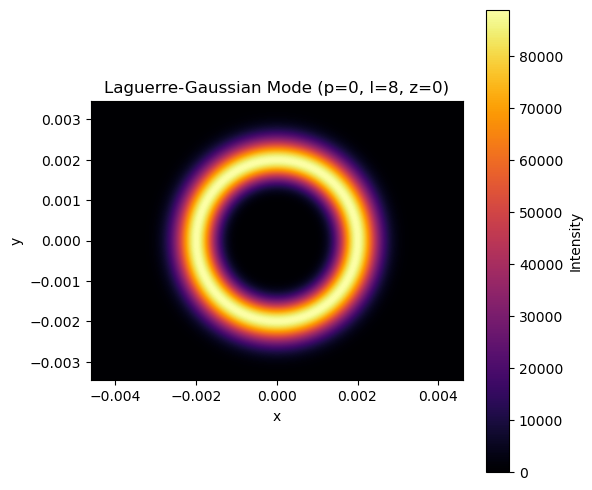

In [14]:

##GENERAR MODOS LAGUERRE GAUSS

from scipy.special import genlaguerre

def laguerre_gauss_mode(p, l, r, phi, z, w0, k):
    """
    Computes the Laguerre-Gaussian mode of light.
    
    Parameters:
        p  : Radial index (non-negative integer)
        l  : Azimuthal index (integer)
        r  : Radial coordinate
        phi: Azimuthal coordinate
        z  : Propagation distance
        w0 : Beam waist
        k  : Wave number
    
    Returns:
        Complex field amplitude of the LG mode.
    """
    z_R = np.pi * w0**2 / k  # Rayleigh range
    w_z = w0 * np.sqrt(1 + (z / z_R) ** 2)  # Beam waist at z
    R_z = z * (1 + (z_R / z) ** 2) if z != 0 else np.inf  # Radius of curvature
    psi_z = np.arctan(z / z_R)  # Gouy phase
    
    C_lp = np.sqrt(2 * np.math.factorial(p) / (np.pi * np.math.factorial(p + abs(l))))
    R = np.sqrt(2) * r / w_z
    L = genlaguerre(p, abs(l))(2 * r**2 / w_z**2)  # Generalized Laguerre polynomial
    
    amplitude = C_lp * (R**abs(l)) * np.exp(-r**2 / w_z**2) * L
    phase = np.exp(-1j * k * r**2 / (2 * R_z)) * np.exp(-1j * l * phi) * np.exp(1j * psi_z)
    
    return (1 / w_z) * amplitude * phase

# Define grid
N = (Nxpix,Nypix)  # Grid size
x = np.linspace(-Nxpix/2*Pix_size, Nxpix/2*Pix_size, Nxpix)
y = np.linspace(-Nypix/2*Pix_size, Nypix/2*Pix_size, Nypix)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
Phi = np.arctan2(Y, X)


# Set LG mode indices and parameters
p, l = 0, 8 # Example mode numbers
w0 = 1000* 10**-6  # Beam waist
z = 0  # Propagation distance
k = 2*np.pi/633e-9  # Wave number

# Compute mode intensity
LG_mode = laguerre_gauss_mode(p, l, R, Phi, z, w0, k)
intensity = np.abs(LG_mode) ** 2

# Plot the intensity pattern
plt.figure(figsize=(6, 6))
plt.imshow(intensity, extent=[-Nxpix/2*Pix_size, Nxpix/2*Pix_size, -Nypix/2*Pix_size, Nypix/2*Pix_size], cmap='inferno')
plt.colorbar(label='Intensity')
plt.title(f'Laguerre-Gaussian Mode (p={p}, l={l}, z={z})')
plt.xlabel('x')
plt.ylabel('y')

plt.savefig(f'FIGURAS\LG_p={p}_l={l}_z={z}).png')
plt.show()

## Función de modos Hermite-Gaussianos:

$$
E_{nm}(x, y, z) = E_0 \frac{w_0}{w(z)}
\cdot H_n \left( \sqrt{2} \frac{x}{w(z)} \right) 
\exp\left( -\frac{x^2}{w^2(z)} \right)
\cdot H_m \left( \sqrt{2} \frac{y}{w(z)} \right) 
\exp\left( -\frac{y^2}{w^2(z)} \right)
$$

$$
\cdot \exp \left( -i \left[ k z - (1 + n + m) \arctan \frac{z}{z_R} 
+ \frac{k(x^2 + y^2)}{2R(z)} \right] \right)
$$


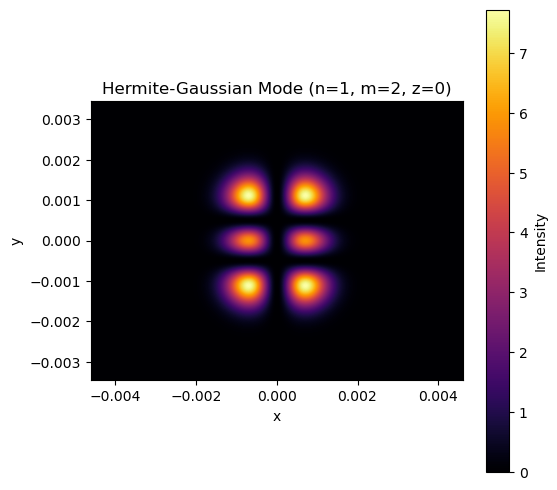

In [15]:


from scipy.special import hermite

def hermite_gauss_mode(n, m, x, y, z, w0, k):
    """
    Computes the Hermite-Gaussian mode of light.
    
    Parameters:
        n  : Mode index along x
        m  : Mode index along y
        x  : x-coordinate
        y  : y-coordinate
        z  : Propagation distance
        w0 : Beam waist
        k  : Wave number
    
    Returns:
        Complex field amplitude of the HG mode.
    """
    z_R = np.pi * w0**2 / k  # Rayleigh range
    w_z = w0 * np.sqrt(1 + (z / z_R) ** 2)  # Beam waist at z
    R_z = z * (1 + (z_R / z) ** 2) if z != 0 else np.inf  # Radius of curvature
    psi_z = (1 + n + m) * np.arctan(z / z_R)  # Gouy phase
    
    X_scaled = np.sqrt(2) * x / w_z
    Y_scaled = np.sqrt(2) * y / w_z
    H_n = hermite(n)(X_scaled)
    H_m = hermite(m)(Y_scaled)
    
    amplitude = (w0 / w_z) * H_n * np.exp(-x**2 / w_z**2) * H_m * np.exp(-y**2 / w_z**2)
    phase = np.exp(-1j * (k * z - psi_z + k * (x**2 + y**2) / (2 * R_z)))
    
    return amplitude * phase


# Define grid
N = (Nxpix,Nypix)  # Grid size
x = np.linspace(-Nxpix/2*Pix_size, Nxpix/2*Pix_size, Nxpix)
y = np.linspace(-Nypix/2*Pix_size, Nypix/2*Pix_size, Nypix)
X, Y = np.meshgrid(x, y)

# Set HG mode indices and parameters
n, m = 1, 2  # Example mode numbers
w0 = 1000* 10**-6  # Beam waist
z = 0  # Propagation distance
k = 2*np.pi/633e-9  # Wave number

# Compute mode intensity
HG_mode = hermite_gauss_mode(n, m, X, Y, z, w0, k)
intensity = np.abs(HG_mode) ** 2

# Plot the intensity pattern
plt.figure(figsize=(6, 6))
plt.imshow(intensity, extent=[-Nxpix/2*Pix_size, Nxpix/2*Pix_size, -Nypix/2*Pix_size, Nypix/2*Pix_size], cmap='inferno')

plt.colorbar(label='Intensity')
plt.title(f'Hermite-Gaussian Mode (n={n}, m={m}, z={z})')
plt.xlabel('x')
plt.ylabel('y')

plt.savefig(f'FIGURAS\HG_n={n}_m={m}_z={z}).png',dpi=300)
plt.show()

##  Este codigo es para importar cualquier imagen, redimensionarla a las dimensiones del SLM, y pasarla a escala escala de grises con valores entre 0 y 255

<function matplotlib.pyplot.show(close=None, block=None)>

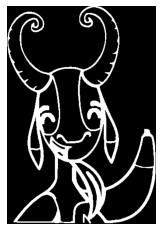

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def resize_image_to_matrix(image_path, width, height):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    if image is None:
        raise ValueError("Image not found or unable to load.")
    
    # Resize the image
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    
    # Convert to a NumPy array with values between 0 and 255
    pixel_matrix = np.array(resized_image, dtype=np.uint8)
    
    pixel_matrix= cv2.bitwise_not(pixel_matrix) 
    
    return pixel_matrix




def resize_drawing(image_path, width, height, scale_factor=1.0,invert=False,flip=False):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found or unable to load.")

    # Resize to ensure the image matches the expected dimensions
    image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)

    # Threshold to create a binary mask of the character
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)  # Invert so character is white

    # Find contours of the character
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        raise ValueError("No character found! Check the image.")

    # Get the bounding box of the character
    x, y, w, h = cv2.boundingRect(contours[0])

    # Extract the character from the original image
    character_crop = binary_image[y:y+h, x:x+w]

    # Resize the extracted character
    new_w, new_h = int(w * scale_factor), int(h * scale_factor)
    resized_character = cv2.resize(character_crop, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Create a new black canvas of the same original size
    new_image = np.zeros((height, width), dtype=np.uint8)

    # Compute new position to center the resized character
    start_x = max((width - new_w) // 2, 0)
    start_y = max((height - new_h) // 2, 0)

    # Ensure it does not exceed image boundaries
    end_x = min(start_x + new_w, width)
    end_y = min(start_y + new_h, height)

    # Copy resized character into the black canvas
    new_image[start_y:end_y, start_x:end_x] = resized_character[:end_y-start_y, :end_x-start_x]


  
    
    if flip:   
        final_image = cv2.flip(new_image, 0)
        
    if invert:   
        final_image = cv2.bitwise_not(new_image)
        
    else:
        
        final_image = new_image
        
        
    return final_image

# Adjust scale_factor to resize the Among Us character
scale_factor = 1  # Increase to make it larger, decrease to shrink

# Process image
Figure = resize_drawing("FIGURAS\SenecaTrace.png", width=342, height=500, scale_factor=1)

# Display image
plt.imshow(Figure, cmap="gray")
plt.axis("off")  # Hide axes

plt.savefig("FIGURAS\SENECA_.png",bbox_inches='tight', transparent="True", pad_inches=0,dpi=300)
plt.show


# 2) Generar hologramas a partir de una funcion de campo electrico complejo

## Patrones de solo fase 


Patrones donde solo se incluye un termino de fase en la funcion de los hologramas. Estos patrones son equivalentes a los patrones generados con la interferencia del campo deseado y un onda plana que incide oblicuamente.

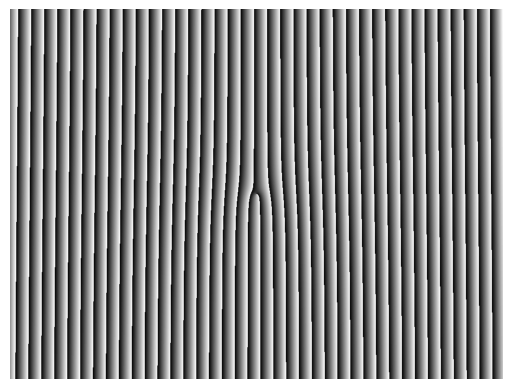

In [16]:
Nxpix = 1024
Nypix = 768
pix_size=9e-6






def Amplitude_Phase_pattern(Desired_Field,LAMBDA,NX,NY):
    
    #A=np.absolute(Desired_Field)
    PHI=np.angle(Desired_Field)
    
    
    
    #M=A/np.max(A)
    F=PHI
    
    
    #print(np.shape(M))
    
    psi=np.zeros([NY,NX])
    
 
    
    for n in range(NY):
        for m in range(NX):
            
            
            psi[n,m]=np.mod(F[n,m] + ( 2* np.pi * m / (3*LAMBDA)), 2*np.pi)
         
    
    
    psi_int=((psi - psi.min()) * (1/(psi.max() - psi.min()) * 255)).astype('uint8')
    
    return  psi_int


LG0_1=laguerre_gauss_mode(0, 1, R, Phi, z, 600e-6, k) #MODO GAUSSIANO


Hologram=Amplitude_Phase_pattern(LG0_1,pix_size,Nxpix,Nypix) ##Variable donde guardamos la matrix de pixeles de valores del holograma

pattern=plt.imshow(Hologram,cmap="gray",aspect='equal')
#Field_int=plt.imshow(np.abs(Output_Field)**2,cmap="gray")
plt.axis('off')
plt.savefig("FIGURAS\HologramPhaseLG01.png",bbox_inches='tight', transparent="True", pad_inches=0,dpi=300)

## Generar los patrones de amplitud-fase que se enviaran al SLM para un campo complejo arbitrario

(E.Bolduc,2013) "Exact solution to simultaneous intensity and phase encryption with a single phase-only hologram"

Estos patrones funcionan modulando la cantidad de luz que se envia al primer orden de difraccion, incluyendo terminos que dependen de la fase y de la amplitud del campo  deseado en la funcion que genera el patron de fase que es enviado al SLM. La  figura deseada se observa en el primer orden.

Se incluye una funcion de contraste que hace que los valores enviados al SLM sean mas parecidos a la curva de modulacion de fase real del SLM. Esto mejora la definicion de las imagenes.Un contraste de $C=1$ no hace nada, $C=255$ es una imagen binaria. Para nuestro SLM, $2<C<5$ da los mejores resultados.


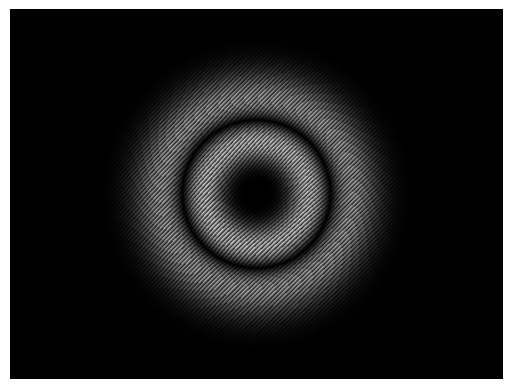

In [31]:

Nxpix = 1024
Nypix = 768
pix_size=9e-6  ##Dimensiones del SLM






##GENERACION DE PATRONES AMPLITUD-FASE SEGUN (E.Bolduc,2013) "Exact solution to simultaneous intensity and phase encryption with a single phase-only hologram"


def contrast_function(C, array):
    y = C * (array - 255/2) + 255/2
    return np.clip(y, 0, 255).astype("uint8")


##GENERACION DE PATRONES AMPLITUD-FASE SEGUN (E.Bolduc,2013) "Exact solution to simultaneous intensity and phase encryption with a single phase-only hologram"

def Amplitude_Phase_pattern(Desired_Field, LAMBDA, NX, NY, Contrast=1):
    A = np.abs(Desired_Field)
    PHI = np.angle(Desired_Field)

    M = A / np.max(A)
    F = PHI - np.pi * M

    # Eliminamos los bucles for usando operaciones vectorizadas
    x = np.arange(NX)
    y = np.arange(NY)
    X, Y = np.meshgrid(x, y, indexing='xy')

    psi = M * np.mod(F + ( 2* np.pi * X / (0.8*LAMBDA)) + (2 * np.pi * Y / (0.8*LAMBDA)) , 2* np.pi)

    psi_int = ((psi - psi.min()) * (255 / (psi.max() - psi.min()))).astype(np.uint8)

    return contrast_function(Contrast, psi_int)




Output_Field=laguerre_gauss_mode(0, -3, R, Phi, z, 700e-6, k)+laguerre_gauss_mode(0, 3, R, Phi, z, 700e-6, k) ##CAMPO ELECTRICO QUE SE QUIERE RECREAR
LG=laguerre_gauss_mode(1, 5, R, Phi, z, 800e-6, k)#MODO GAUSSIANO
HG=hermite_gauss_mode(1, 2, X, Y, z, 800e-6, k)

Hologram=Amplitude_Phase_pattern(LG,pix_size,Nxpix,Nypix,Contrast=1) ##Variable donde guardamos la matrix de pixeles de valores del holograma

pattern=plt.imshow(Hologram,cmap="gray",aspect='equal')
#Field_int=plt.imshow(np.abs(Output_Field)**2,cmap="gray")
plt.axis('off')
plt.savefig("FIGURAS\Hologramas\HologramLG15",bbox_inches='tight', transparent="True", pad_inches=0,dpi=300)






# 3)Generar Hologramas para patrones de intensidad donde no se tiene informacion de fase 

## Sacar el patron de fase-Amplitud de la transformada de fourier bidimensional de una imagen cargada

Aqui encontramos la fase de la transformada de fourier de un patron de intensidad (Imagen), para enviarla al SLM. Como se pierde toda la informacion de la amplitud de la transformada de fourier, al propagar el campo al plano de fourier no se obtiene exactamente el campo deseado.


Para observar figuras es necesario poner un sistema 2f en frente del SLM

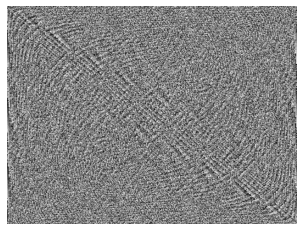

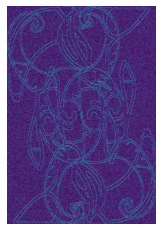

In [5]:
## FFT DE IMAGEN

from scipy.fft import ifftn
from scipy.fft import fftn


import cv2



Nxpix = 1024
Nypix = 768
pix_size=9e-6  ##Dimensiones del SLM




def resize_image_to_matrix_im(image, width, height):
 
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    

    
    return resized_image



FFTFigure=fftn(Figure)

#FFTHologram=Amplitude_Phase_pattern(ifftn(Figure),pix_size,Nxpix,Nypix)
FFTHologram=resize_image_to_matrix_im(np.angle(fftn(Figure)),Nxpix,Nypix) #Patron de solo fase


plt.figure(1)

plt.axis('off')
plt.imshow(FFTHologram,cmap="gray",aspect='equal')



plt.savefig("Figuras\FFTHologram.png",bbox_inches='tight', transparent="True", pad_inches=0,dpi=300)


plt.figure(2)


Magnitude=np.abs(ifftn (np.angle(fftn(Figure))))
#plt.imshow(Magnitude)
Magnitudeint=(((Magnitude - Magnitude.min()) * (1/(Magnitude.max() - Magnitude.min()) * 255)).astype('uint8')) ## Reconstruccion teorica de la imagen
                                                                                                            ## en plano de fourier
plt.axis('off')
plt.imshow(Magnitudeint)
plt.savefig("Figuras\RECONSTRUCTIONANGLE.png",bbox_inches='tight', transparent="True", pad_inches=0,dpi=300)


## ITERATIVE FOURIER HOLOGRAMS

Este codigo genera un patron de fase a partir de una imagen cargada, que generara el patron de intensidad deseado despues de propagarse por un sistema 2f.


Como el SLM recibe solamente informacion de fase, necesitamos enviar una mascara de fase tal que al realizar la difraccion por un sistema 2f (T.Fourier) se recree el patron de intensidad que deseamos. Como no tenemos informacion sobre la fase del patron de intensidad,se implementan algoritmos de reconstruccion de fase.


Los patrones y el calculo de la difraccion se hacen con la libreria "diffractsim" (https://github.com/rafael-fuente/diffractsim), el cual usa el metodo del espectro angular para propagar la luz. Los hologramas se hacen con un algoritmo de reconstruccion de fase descrito en $\textit{J. R. Fienup, "Phase retrieval algorithms: a comparison," Appl. Opt. 21, 2758-2769 (1982)}$. Para estos patrones se observa la figura en el plano de Fourier, por lo que hay que poner un sistema 2f delante del SLM.

100% |########################################################################|


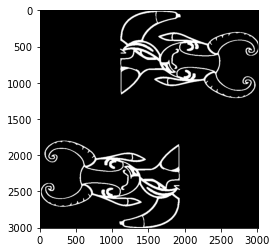

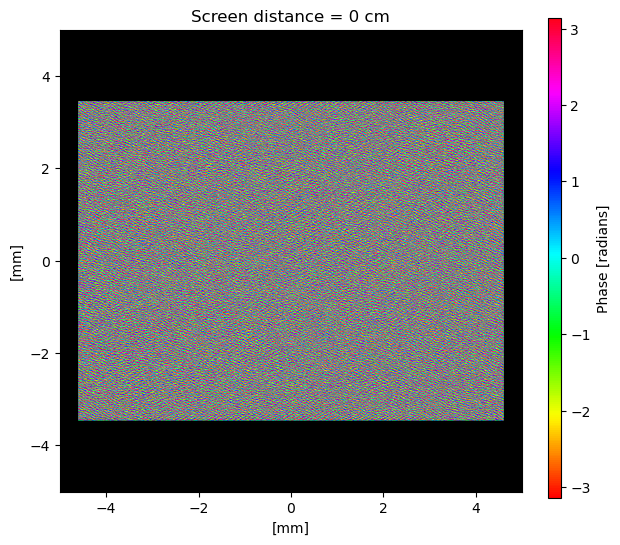

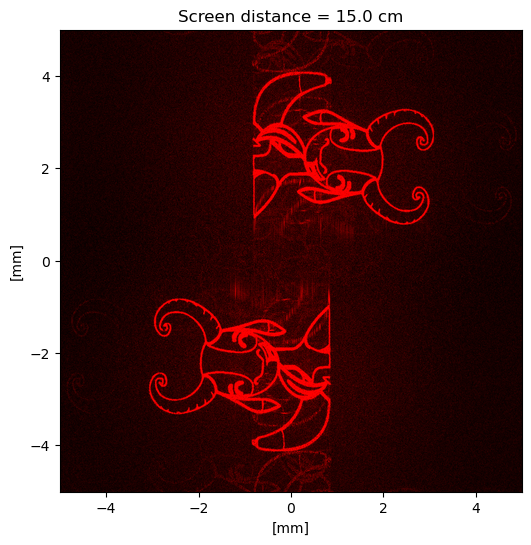

"\nfig = plt.figure(figsize=(8,5))\nax = fig.add_subplot()\nscale=1\ndeltaz=0.2\nz=np.arange(0,17,deltaz)\nframes=np.zeros([1300,1300,len(z)])\n\n\nfor i in tqdm(range(len(z))):\n    \n \n    \n    if z[i]>15:\n        \n        z[i]=15\n        \n        frames[:,:,i]=np.abs(F.get_field())\n    \n    \n    else:\n        \n        F.propagate(deltaz*cm)\n        frames[:,:,i]=np.abs(F.get_field())\n\n\ndef init():\n    \n    ax.clear()\n        \ndef Update(i):\n    \n    Image=ax.imshow(frames[:,:,i])\n    ax.set_title(r'z={:.3f}cm'.format(z[i]))\n   \n    return Image\n    \n    \n    \nAnimation = anim.FuncAnimation(fig,Update,frames=len(z)-1,init_func=init)\n\n# To save the animation using Pillow as a gif\nwriter = anim.PillowWriter(fps=15,metadata=dict(artist='Andres A'),bitrate=1800)\nAnimation.save('Hologramgeneration_Logo.gif', writer=writer)\n\n# plot colors (reconstructed image) at z = 80*cm (Fourier plane)\n"

In [7]:
from diffractsim import MonochromaticField, ApertureFromImage, Lens, mm, nm, cm, FourierPhaseRetrieval
import cv2

Intensity_Pattern='./aperturas/SenecaDupla.png'
plt.imshow(cv2.imread(Intensity_Pattern))

           
           
#Generar holograma
PR = FourierPhaseRetrieval(target_amplitude_path =Intensity_Pattern , new_size= (600,600), pad = (212,84))
PR.retrieve_phase_mask(max_iter = 15, method = 'Conjugate-Gradient'),
PR.save_retrieved_phase_as_image("Seneca_Mat_phase_hologram.png",phase_mask_format="graymap") ## Patron de fase se guarda en escala de grises


#Añadir onda plana
F = MonochromaticField(
    wavelength=632 * nm, extent_x=10 * mm, extent_y=10 * mm, Nx=1300, Ny=1300, intensity = 0.005
)


#Se carga el holograma como una mascara de phase
F.add(ApertureFromImage(
     amplitude_mask_path= "./aperturas/white_background.png", 
     phase_mask_path= "Seneca_Mat_phase_hologram.png", image_size=(9.216 * mm, 6.912 * mm), simulation = F,phase_mask_format="graymap"))

#Mostrar phase en z=0
rgb = F.get_field()
F.plot_phase(rgb)




#Propagar el campo al plano de foureir
F.add(Lens(f = 15*cm))##Añadir lente de f=150mm
F.propagate(15*cm)



rgb = F.get_colors()
F.plot_colors(rgb)


###Esto es para crear animacion en diferentes valores de z

"""
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
scale=1
deltaz=0.2
z=np.arange(0,17,deltaz)
frames=np.zeros([1300,1300,len(z)])


for i in tqdm(range(len(z))):
    
 
    
    if z[i]>15:
        
        z[i]=15
        
        frames[:,:,i]=np.abs(F.get_field())
    
    
    else:
        
        F.propagate(deltaz*cm)
        frames[:,:,i]=np.abs(F.get_field())


def init():
    
    ax.clear()
        
def Update(i):
    
    Image=ax.imshow(frames[:,:,i])
    ax.set_title(r'z={:.3f}cm'.format(z[i]))
   
    return Image
    
    
    
Animation = anim.FuncAnimation(fig,Update,frames=len(z)-1,init_func=init)

# To save the animation using Pillow as a gif
writer = anim.PillowWriter(fps=15,metadata=dict(artist='Andres A'),bitrate=1800)
Animation.save('Hologramgeneration_Logo.gif', writer=writer)

# plot colors (reconstructed image) at z = 80*cm (Fourier plane)
"""


## Add Fresnel plate ( Patron de fase de un lente ) 

Goodman, J.W. (1968) Introduction to Fourier Optics. McGraw-Hill, San Francisco, CA.

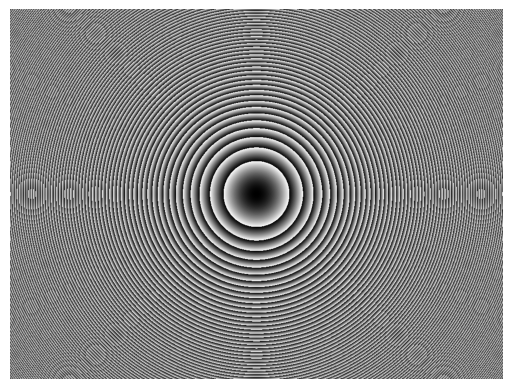

In [9]:

def Fresnel_Grating(f,k): ##Este patron actua como un lente con distancia focal f
    
    NY=768
    NX=1024
    Pixsize=9e-6
    psi=np.zeros([NY,NX])
    
    x = np.linspace(-NX/2*Pixsize, NX/2*Pixsize, NX)
    y = np.linspace(-NY/2*Pixsize, NY/2*Pixsize, NY)
    


    
    
    for n in range(NY):
        for m in range(NX):
            
            psi[n,m]=np.mod( (k* (x[m]**2+y[n]**2))/(2*f) , 2*np.pi)
           

                            
    psi_int=((psi - psi.min()) * (1/(psi.max() - psi.min()) * 255)).astype('uint8')
    return psi_int



def resize_image_to_matrix(image_path, width, height):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    if image is None:
        raise ValueError("Image not found or unable to load.")
    
    # Resize the image
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    
    # Convert to a NumPy array with values between 0 and 255
    pixel_matrix = np.array(resized_image, dtype=np.uint8)
    
    
    
    return pixel_matrix


k=2*np.pi/632e-9

FresnelHologram=Fresnel_Grating(300e-3,k)

plt.axis("off")
plt.imshow(FresnelHologram,cmap="gray")

plt.savefig("Fresnel_phase_hologram_f=300mm.png",bbox_inches='tight', transparent="True", pad_inches=0,dpi=300)


# 4) Enviar imagen al SLM

## Mostrar una imagen en pantalla completa (screen_index=0 es monitor, screen_index=1 es segunda pantalla (SLM))

### Cerrar la ventana con "q" antes de correr cualquier otra celda

Se incluye una funcion de contraste que hace que los valores enviados al SLM sean mas parecidos a la curva de modulacion de fase real del SLM. Esto mejora la definicion de las imagenes.Un contraste de $C=1$ no hace nada, $C=255$ es una imagen binaria. Para nuestro SLM, $2<C<5$ de los mejores resultados.


In [11]:


##MOSTRAR IMAGEN EN PANTALLLA
import cv2
import screeninfo

def contrast_function(C, array):
    y = C * (array - 255/2) + 255/2
    return np.clip(y, 0, 255).astype("uint8")



def show_fullscreen_image(image_path, screen_index=0,Contrast=1):
    # Load the image
    image = cv2.imread(image_path)
    
    # Check if image is loaded successfully
    if image is None:
        print("Error: Unable to load image.")
        return
    
    
    # Get screen dimensions
    screens = screeninfo.get_monitors()
    if screen_index >= len(screens):
        print("Error: Screen index out of range.")
        return
    
    screen = screens[screen_index]
    screen_width, screen_height = screen.width, screen.height
    
    # Resize the image to fit the screen dimensions
    image = cv2.resize(image, (screen_width, screen_height))
    
    image=contrast_function(Contrast,image)
    # Create a named window and move it to the selected screen
    cv2.namedWindow("Fullscreen Image", cv2.WND_PROP_FULLSCREEN)
    cv2.moveWindow("Fullscreen Image", screen.x, screen.y)
    cv2.setWindowProperty("Fullscreen Image", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    # Show the image
    cv2.imshow("Fullscreen Image", image)
    
    # Wait for a key press and close the window
    while True:
        k = cv2.waitKey(0) & 0xFF
        
        if k == ord('q'): #CERRAR VENTANA CON "q"
            cv2.destroyAllWindows()
            break

Imagen_SLM="FIGURAS/Hologramas/Seneca_Mat_phase_hologram.png"
show_fullscreen_image(Imagen_SLM,screen_index=0,Contrast=2.1)#SCREEN_INDEX=0 (Pantalla principal) , 1 segunda pantalla (SLM) 
